In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys


In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

# In a terminal, run these
#   export PYTHONPATH=/home/patrice/work/ppsp/pywt:$PYTHONPATH
#   export PYTHONPATH=/home/patrice/work/ppsp/pycwt:$PYTHONPATH
# Then open code from the terminal
# 
# Or, use this (but vscode will not be able to resolve the import)
# sys.path.insert(0, '/home/patrice/work/ppsp/pywt')
# sys.path.insert(0, '/home/patrice/work/ppsp/pycwt')

import pywt  # the library we want to use
import pycwt # the library we don't want to use (hardcoded stuff, no tests)

import hypyp
import hypyp.signal



ninja: error: '/tmp/pip-build-env-tiw5qk87/overlay/bin/cython', needed by 'pywt/_extensions/_cwt.cpython-311-x86_64-linux-gnu.so.p/_cwt.c', missing and no known rule to make it


Loading pwt from /home/patrice/work/ppsp/pywt/pywt


In [3]:
wavelet = pywt.ContinuousWavelet('cmor2.0, 1.0')
print(wavelet)


ContinuousWavelet cmor2.0, 1.0
  Family name:    Complex Morlet wavelets
  Short name:     cmor
  Symmetry:       asymmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True


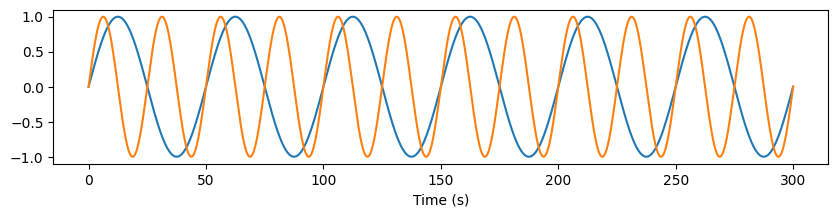

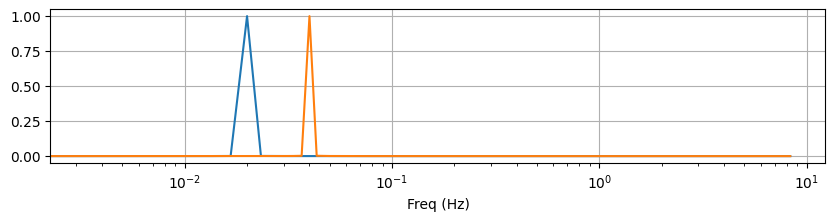

In [4]:
signals = [
    hypyp.signal.SynteticSignal(tmax=5*60, n_points=5000).gen_sin(0.02),
    hypyp.signal.SynteticSignal(tmax=5*60, n_points=5000).gen_sin(0.04)
]

plt.figure(figsize=(10, 2))
[sig.plot() for sig in signals]
plt.show()

plt.figure(figsize=(10,2))
[sig.plot_fft() for sig in signals]
plt.grid()
plt.show()

In [5]:
%connect_info

{"key":"255c3082-2a98-4f95-a1f3-e93063238510","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9008,"control_port":9009,"shell_port":9010,"stdin_port":9011,"iopub_port":9012,"kernel_name":"python3112jvsc74a57bd04149aa2f31a7f8b5ff184e82bf464dce73529b69401cc2940ad6232b832b4da8"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v3b13a6ee2666ba238a1852702cbf115f4a95bd4ed.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


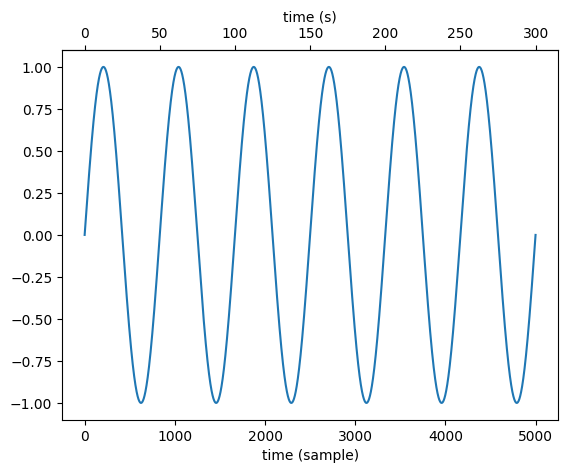

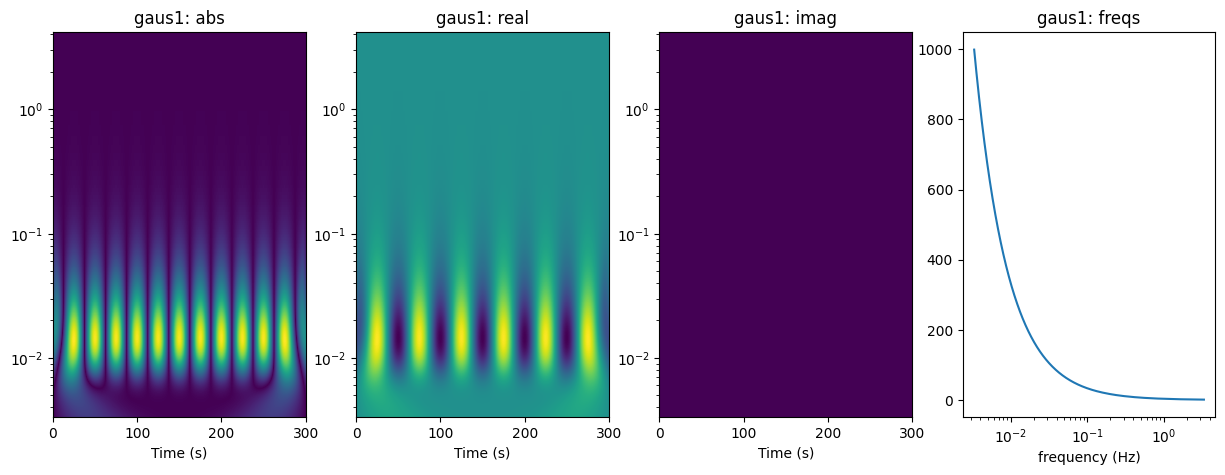

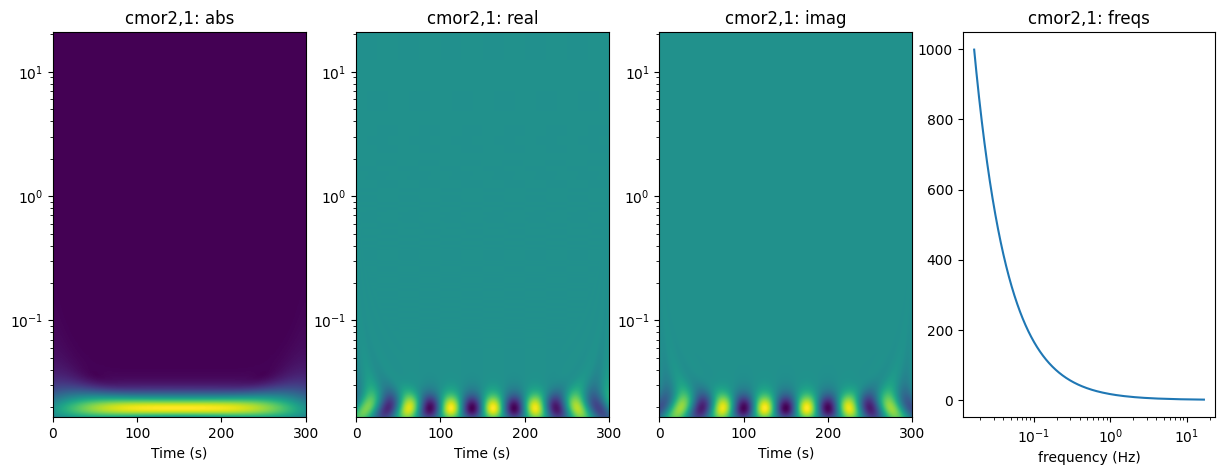

In [6]:
#from matplotlib.ticker import FuncFormatter

sig = signals[0].y
times = signals[0].times_vec
sample_rate = signals[0].sample_rate

fig, ax = plt.subplots()
def time_s_axis(x):
    return x / sample_rate
def freq_hz(wavelet):
    def fn(scale):
        return pywt.scale2frequency(wavelet, scale) * sample_rate
    return fn
ax.plot(sig)
ax.set_xlabel(f'time (sample)')
secax = ax.secondary_xaxis('top', functions=(time_s_axis, time_s_axis))
secax.set_xlabel('time (s)')
plt.show()

scales = np.arange(1, 1000)
all_params = [
    ('gaus1', scales),
    ('cmor2,1', scales)
]
for wavelet_name, scales in all_params:
    W, freqs = pywt.cwt(sig, scales=scales, wavelet=wavelet_name, sampling_period=1/sample_rate)
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    #axes[0].imshow(np.abs(W), aspect='auto', cmap='jet', extent=[0, len(sig)/sample_rate, freqs[-1], freqs[0]])
    #axes[0].imshow(np.abs(W), aspect='auto', cmap='jet', extent=[0, len(sig)/sample_rate, freqs[-1], freqs[0]])
    axes[0].pcolormesh(times, freqs, np.abs(W))
    axes[0].title.set_text(f'{wavelet_name}: abs')
    #axes[1].imshow(np.real(W), aspect='auto', cmap='jet', extent=[0, len(sig)/sample_rate, freqs[-1], freqs[0]])
    axes[1].pcolormesh(times, freqs, np.real(W))
    axes[1].title.set_text(f'{wavelet_name}: real')
    #axes[2].imshow(np.imag(W), aspect='auto', cmap='jet', extent=[0, len(sig)/sample_rate, freqs[-1], freqs[0]])
    axes[2].pcolormesh(times, freqs, np.imag(W))
    axes[2].title.set_text(f'{wavelet_name}: imag')
    #plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / signals[0].sample_rate:.1f}'))
    for ax in axes[:3]:
        ax.set_yscale("log")
        ax.set_xlabel("Time (s)")
        #secax = ax.secondary_xaxis('top', functions=(time_s_axis, time_s_axis))
        #secax.set_xlabel('time (s)')
    axes[3].plot(freqs, scales)
    axes[3].title.set_text(f'{wavelet_name}: freqs')
    axes[3].set_ylabel('')
    axes[3].set_xlabel('frequency (Hz)')
    axes[3].set_xscale('log')
    plt.show()



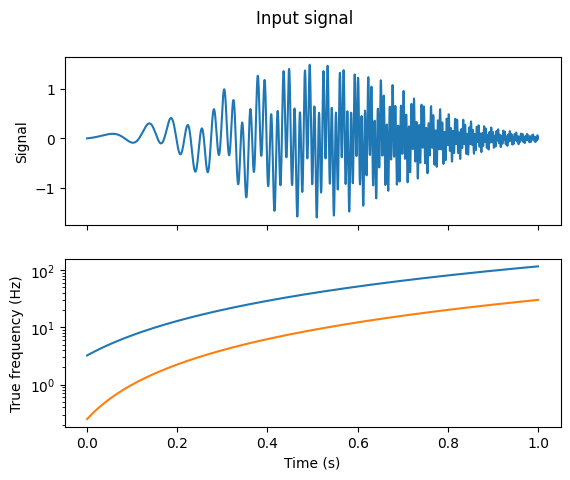

In [7]:
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


# generate signal
time = np.linspace(0, 1, 2000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)

# plot signal
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, chirp)
axs[1].plot(time, frequency1)
axs[1].plot(time, frequency2)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()


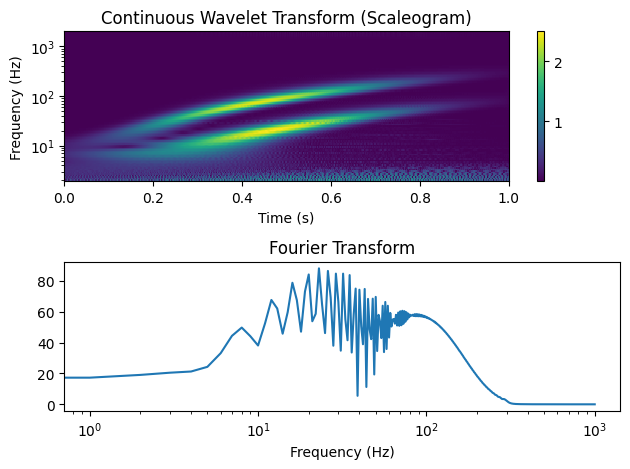

In [8]:
# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
scales = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, scales, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()



Text(0, 0.5, 'amplitude')

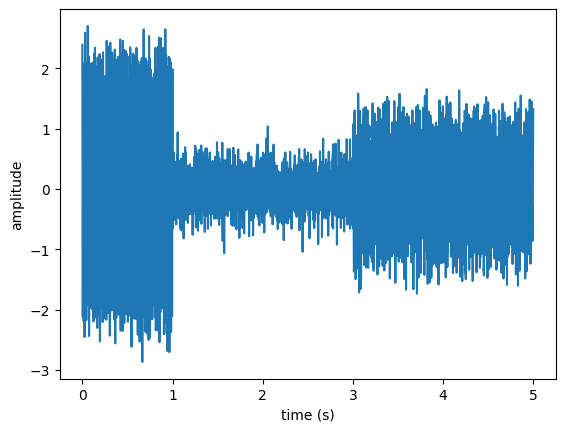

In [9]:
# From https://www.mathworks.com/help/wavelet/gs/continuous-wavelet-analysis.html

fs = 1000
n = 5000
x = np.linspace(0, 5, n);
sig = 2 * np.cos(2*np.pi*100*x) * (x < 1) + np.cos(2*np.pi*50*x) * (3<x) + 0.3 * np.random.normal(0,1,n)

plt.plot(x, sig)
plt.xlabel('time (s)')
plt.ylabel('amplitude')


In [47]:
bandwidth_freqs = [1, 2, 3, 5]
center_freqs = [0.5, 1, 1.5, 3]

fig, axes = plt.subplots(len(bandwidth_freqs), len(center_freqs), figsize=(15, 15))
for i, bandwidth_freq in enumerate(bandwidth_freqs):
    for j, center_freq in enumerate(center_freqs):
        wavelet_name = f"cmor{bandwidth_freq},{center_freq}"
        ax = axes[i,j]
        
        scales = np.geomspace(0.1, 1024, num=100)
        W, freqs = pywt.cwt(sig, scales, wavelet_name, sampling_period=1/fs)
        ax.pcolormesh(x, freqs, np.abs(W), cmap='jet')
        #ax.set_ylim(0, 200)
        ax.set_yscale('log')
        #ax.colorbar()
        ax.title.set_text(wavelet_name)
        if i == len(bandwidth_freqs)-1:
            ax.set_xlabel('time (s)')
        if j == 0:
            ax.set_ylabel('frequency (Hz)')
